# Task 1

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt

In [2]:
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras
import json

credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        try:
            db = create_engine('postgresql+psycopg2://'+db_user+':'+db_pw+'@'+host+'/'+default_db, echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(sqlcmd, args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

In [3]:
db, conn = pgconnect(credentials)
query(conn, "select PostGIS_Version()")

Connected successfully.


,postgis_version
0,3.3 USE_GEOS=1 USE_PROJ=1 USE_STATS=1


### 1.1 Clean the data

#### Population

In [4]:
population = pd.read_csv('Population.csv')
population = population[population['total_people'] >= 100]
population['young_people'] = population['0-4_people'] + population['5-9_people'] + population['10-14_people'] + population['15-19_people']
population = population[['sa2_code', 'sa2_name', 'young_people', 'total_people']]
population = population.dropna()
population = population.drop_duplicates()
population

,sa2_code,sa2_name,young_people,total_people
0,102011028,Avoca Beach - Copacabana,2121,7530
1,102011029,Box Head - MacMasters Beach,2471,11052
2,102011030,Calga - Kulnura,961,4748
3,102011031,Erina - Green Point,3205,14803
4,102011032,Gosford - Springfield,4364,21346
...,...,...,...,...
367,128021536,Oyster Bay - Como - Jannali,6212,22151
369,128021538,Sutherland - Kirrawee,5078,23369
370,128021607,Engadine,5118,17379
371,128021608,Loftus - Yarrawarrah,2073,7354


#### Business 

In [5]:
businesses = pd.read_csv('Businesses.csv')
target_business = ["Retail Trade","Health Care and Social Assistance"]
businesses = businesses[(businesses['industry_name'].isin(target_business))]
businesses = businesses[(businesses['sa2_code'].isin(population['sa2_code']))]
businesses = businesses[['industry_code', 'industry_name','sa2_code', 'sa2_name','total_businesses']]
businesses = businesses.dropna()
businesses = businesses.drop_duplicates()
businesses

,industry_code,industry_name,sa2_code,sa2_name,total_businesses
3886,G,Retail Trade,102011028,Avoca Beach - Copacabana,45
3887,G,Retail Trade,102011029,Box Head - MacMasters Beach,50
3888,G,Retail Trade,102011030,Calga - Kulnura,57
3889,G,Retail Trade,102011031,Erina - Green Point,152
3890,G,Retail Trade,102011032,Gosford - Springfield,180
...,...,...,...,...,...
10924,Q,Health Care and Social Assistance,128021536,Oyster Bay - Como - Jannali,96
10926,Q,Health Care and Social Assistance,128021538,Sutherland - Kirrawee,178
10927,Q,Health Care and Social Assistance,128021607,Engadine,77
10928,Q,Health Care and Social Assistance,128021608,Loftus - Yarrawarrah,22


#### Stops

In [6]:
stops = pd.read_csv('Stops.txt')
stops = stops.drop(['stop_code', 'location_type', 'parent_station', 'wheelchair_boarding', 'platform_code'], axis=1)
stops = stops.dropna()
stops = stops.drop_duplicates()

stops['geom'] = gpd.points_from_xy(stops.stop_lon, stops.stop_lat)
stops = stops.drop(columns=['stop_lon', 'stop_lat'])
srid = 4283
stops['geom'] = stops['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))
stops

,stop_id,stop_name,geom
0,200039,"Central Station, Eddy Av, Stand A",POINT (151.20666465471 -33.8822064874687)
1,200054,"Central Station, Eddy Av, Stand D",POINT (151.20699145565 -33.8820421431408)
2,200060,Central Station,POINT (151.206292455081 -33.8840842535493)
3,201510,Redfern Station,POINT (151.198866071817 -33.8916900512711)
4,201646,"Redfern Station, Gibbons St, Stand B",POINT (151.198881722942 -33.8933293130144)
...,...,...,...
114713,212753,"Sydney Olympic Park Wharf, Side B",POINT (151.07879697831 -33.8220164586429)
114714,2137185,"Cabarita Wharf, Side A",POINT (151.116926480557 -33.8406690716775)
114715,2137186,"Cabarita Wharf, Side B",POINT (151.116898892402 -33.8407691073139)
114716,21501,Parramatta Wharf,POINT (151.010576673346 -33.8139042429414)


#### Polls

In [7]:
polls = pd.read_csv('PollingPlaces2019.csv')
polls = polls.drop(['state', 'FID', 'polling_place_type_id', 'premises_address_1', 'premises_address_2', 
                    'premises_address_3', 'premises_suburb', 'premises_post_code', 'premises_state_abbreviation', 
                    'the_geom', 'premises_name'], axis=1)
polls = polls.dropna()
polls = polls.drop_duplicates()

polls['geom'] = gpd.points_from_xy(polls.longitude, polls.latitude)
polls = polls.drop(columns=['longitude','latitude'])
srid = 4283
polls['geom'] = polls['geom'].apply(lambda x: WKTElement(x.wkt, srid=srid))
polls

,division_id,division_name,polling_place_id,polling_place_name,geom
13,103,Banks,58,Oatley,POINT (151.081 -33.9847)
15,111,Chifley,392,Dharruk,POINT (150.817 -33.7475)
16,103,Banks,31,Allawah,POINT (151.1148974 -33.9767897)
17,103,Banks,67,Allawah South,POINT (151.111 -33.9756)
18,103,Banks,56500,Beverly Hills North (Banks),POINT (151.075 -33.9413)
...,...,...,...,...,...
2924,150,Whitlam,2810,Warilla North,POINT (150.85177 -34.54724)
2925,150,Whitlam,2809,Warilla South,POINT (150.858 -34.5642)
2926,150,Whitlam,58798,Warilla WHITLAM PPVC,POINT (150.8597546 -34.5508228)
2927,150,Whitlam,31242,Welby,POINT (150.424 -34.4409)


#### Income

In [8]:
income = pd.read_csv('Income.csv')
income = income[income.median_age != 'np']
income['median_age'] = pd.to_numeric(income['median_age'])
income['median_income'] = pd.to_numeric(income['median_income'])
income['mean_income'] = pd.to_numeric(income['mean_income'])
income['earners'] = pd.to_numeric(income['earners'])
income = income[(income['sa2_code'].isin(population['sa2_code']))]
income

,sa2_code,sa2_name,earners,median_age,median_income,mean_income
27,102011028,Avoca Beach - Copacabana,4788,47,52450,71977
28,102011029,Box Head - MacMasters Beach,6647,49,48724,64621
29,102011030,Calga - Kulnura,2919,49,46228,61545
30,102011031,Erina - Green Point,7962,48,48292,67162
31,102011032,Gosford - Springfield,11439,42,51999,62478
...,...,...,...,...,...,...
570,128021536,Oyster Bay - Como - Jannali,13480,45,64428,83285
572,128021538,Sutherland - Kirrawee,13698,41,62453,71105
573,128021607,Engadine,10335,43,60914,70158
574,128021608,Loftus - Yarrawarrah,4498,45,60469,73218


#### SA2 Regions

In [9]:
SA2 = gpd.read_file("SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp")
SA2 = SA2[SA2['GCC_NAME21'] == "Greater Sydney"]
SA2.rename(columns={"SA2_CODE21": "sa2_code", "SA2_NAME21": "sa2_name",}, inplace=True)
SA2['sa2_code'] = pd.to_numeric(SA2['sa2_code'])
SA2 = SA2.dropna()
SA2 = SA2.drop_duplicates()
SA2 = SA2[(SA2['sa2_code'].isin(population['sa2_code']))]
SA2 = SA2[['sa2_code', 'sa2_name', 'geometry']]

def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

SA2og = SA2.copy()
SA2['geom'] = SA2['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))
SA2 = SA2.drop(columns="geometry")

SA2

,sa2_code,sa2_name,geom
28,102011028,Avoca Beach - Copacabana,MULTIPOLYGON (((151.413733024921 -33.465580583...
29,102011029,Box Head - MacMasters Beach,MULTIPOLYGON (((151.37484081570685 -33.5005199...
30,102011030,Calga - Kulnura,MULTIPOLYGON (((151.20449037540152 -33.5328022...
31,102011031,Erina - Green Point,MULTIPOLYGON (((151.37193611462118 -33.4369790...
32,102011032,Gosford - Springfield,MULTIPOLYGON (((151.32348639265098 -33.4277852...
...,...,...,...
636,128021536,Oyster Bay - Como - Jannali,MULTIPOLYGON (((151.07860617130655 -33.9974761...
638,128021538,Sutherland - Kirrawee,MULTIPOLYGON (((151.05006441218998 -34.0215774...
639,128021607,Engadine,MULTIPOLYGON (((150.99568346574816 -34.0536082...
640,128021608,Loftus - Yarrawarrah,MULTIPOLYGON (((151.03954821100714 -34.0417452...


#### Schools

In [10]:
primary = gpd.read_file("catchments/catchments_primary.shp")
secondary = gpd.read_file("catchments/catchments_secondary.shp")
future = gpd.read_file("catchments/catchments_future.shp")

In [11]:
schools = gpd.pd.concat([primary,secondary, future], axis=0)
schools = schools[['USE_ID', 'CATCH_TYPE', 'geometry']]
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

schools['geom'] = schools['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))
schools = schools.drop(columns="geometry")

schools

,USE_ID,CATCH_TYPE,geom
0,2838,PRIMARY,MULTIPOLYGON (((150.93563850416004 -33.7161211...
1,2404,PRIMARY,MULTIPOLYGON (((151.1833640465581 -33.74748398...
2,4393,PRIMARY,MULTIPOLYGON (((151.0451821055135 -33.77303212...
3,4615,PRIMARY,MULTIPOLYGON (((150.92567327976582 -33.7296030...
4,3918,PRIMARY,MULTIPOLYGON (((151.1537883781186 -33.75586174...
...,...,...,...
25,8554,HIGH_COED,MULTIPOLYGON (((152.3768206204895 -30.98231105...
26,8364,HIGH_COED,MULTIPOLYGON (((152.92687910271997 -31.4405050...
27,8395,HIGH_COED,MULTIPOLYGON (((150.96083230623992 -33.7793953...
28,8892,HIGH_COED,MULTIPOLYGON (((151.0196486925351 -33.80865925...


### 1.2 Import datasets into PostgreSQL server

In [12]:
# Drop CASCADE 
sql = """
DROP VIEW IF EXISTS z_score;
DROP VIEW IF EXISTS new_z_score;
DROP VIEW IF EXISTS z_retail;
DROP VIEW IF EXISTS retail_ratio;
DROP VIEW IF EXISTS z_health;
DROP VIEW IF EXISTS health_ratio;
DROP VIEW IF EXISTS z_stops;
DROP VIEW IF EXISTS no_stops;
DROP VIEW IF EXISTS z_polls;
DROP VIEW IF EXISTS no_polls;
DROP VIEW IF EXISTS z_school;
DROP VIEW IF EXISTS school_ratio;
DROP VIEW IF EXISTS z_gov;
DROP VIEW IF EXISTS gov_area;
DROP VIEW IF EXISTS z_poles;
DROP VIEW IF EXISTS no_poles;
DROP VIEW IF EXISTS z_homeless;
DROP VIEW IF EXISTS total_homeless;
DROP VIEW IF EXISTS z_internet;
DROP VIEW IF EXISTS total_internet
"""
query(db, sql)

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [13]:
# Create a new schema
conn.execute("""
CREATE SCHEMA IF NOT EXISTS greatersydneyanalysis;
SET search_path to greatersydneyanalysis;"""
)

# Drop table if exists
conn.execute("""
DROP TABLE IF EXISTS Businesses;
DROP TABLE IF EXISTS Population;
DROP TABLE IF EXISTS Income;
DROP TABLE IF EXISTS stops;
DROP TABLE IF EXISTS polls;
DROP TABLE IF EXISTS schools;
DROP TABLE IF EXISTS sa2regions
;"""
)

# SA2_Region
conn.execute("""
CREATE TABLE sa2regions(
   sa2_code INTEGER PRIMARY KEY,
   sa2_name VARCHAR(100),
   geom public.GEOMETRY(MULTIPOLYGON,4326)
);"""
)

# Businesses
conn.execute("""
CREATE TABLE Businesses(
   industry_code VARCHAR(1),
   industry_name VARCHAR(50),
   sa2_code INTEGER REFERENCES sa2regions(sa2_code),
   sa2_name VARCHAR(100),
   total_businesses INTEGER,
   PRIMARY KEY (industry_code, sa2_code)
);"""
)

# Income
conn.execute("""
CREATE TABLE Income(
   sa2_code INTEGER REFERENCES sa2regions(sa2_code),
   sa2_name VARCHAR(100),
   earners INTEGER,
   median_age INTEGER,
   median_income INTEGER,
   mean_income INTEGER,
   PRIMARY KEY (sa2_code, sa2_name)
);"""
)

#Population
conn.execute("""
CREATE TABLE Population(
   sa2_code INTEGER REFERENCES sa2regions(sa2_code),
   sa2_name VARCHAR(100),
   young_people INTEGER,
   total_people INTEGER,
   PRIMARY KEY (sa2_code, sa2_name)
);"""
)

# stops
conn.execute("""
CREATE TABLE stops(
   stop_id VARCHAR(50) PRIMARY KEY,
   stop_name VARCHAR(100),
   geom public.GEOMETRY(POINT,4326)
);"""
)

# polls
conn.execute("""
CREATE TABLE polls(
   division_id INTEGER,
   division_name VARCHAR(100),
   polling_place_id INTEGER,
   polling_place_name VARCHAR(100),
   geom public.GEOMETRY(POINT,4326),
   PRIMARY KEY (division_id, polling_place_id)
);"""
)

# schools
conn.execute("""
CREATE TABLE schools(
   USE_ID VARCHAR(10) PRIMARY KEY,
   CATCH_TYPE VARCHAR(50),
   geom public.GEOMETRY(MULTIPOLYGON,4326)
);"""
)

In [14]:
from sqlalchemy import inspect
inspect(db).get_table_names(schema='greatersydneyanalysis')

['poles',
 'gov',
 'homelessness',
 'primaryschools',
 'secondaryschools',
 'futureschools',
 'income',
 'population',
 'stops',
 'sa2regions',
 'businesses',
 'polls',
 'schools']

In [15]:
businesses.to_sql('businesses', db, if_exists='replace', index=False)
income.to_sql('income', db, if_exists='replace', index=False)
population.to_sql('population', db, if_exists='replace', index=False)
stops.to_sql('stops', db, if_exists='replace', index=False, dtype={'geom': Geometry('POINT', srid)})
polls.to_sql('polls', db, if_exists='replace', index=False, dtype={'geom': Geometry('POINT', srid)})
SA2.to_sql("sa2regions", db, if_exists='replace', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
schools.to_sql("schools", db, if_exists='replace', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})

128

# Task 2

### Retail

In [16]:
sql = """
DROP VIEW IF EXISTS z_retail;
DROP VIEW IF EXISTS retail_ratio;

CREATE INDEX retail_no_retail ON businesses(total_businesses);
CREATE INDEX population_total_people ON population(total_people);

CREATE VIEW retail_ratio AS
    SELECT r.sa2_code, r.sa2_name, b.total_businesses as no_retail, p.total_people as population,
            (CAST (b.total_businesses*1000 AS FLOAT)/p.total_people) as retail_ratio
    FROM sa2regions r join population p on (r.sa2_code = p.sa2_code) join businesses b on (p.sa2_code = b.sa2_code)
    WHERE b.industry_name = 'Retail Trade';


CREATE VIEW z_retail AS
    WITH retail_stats AS
        (SELECT avg(retail_ratio) as mean,
                stddev_samp(retail_ratio) as sd
        FROM retail_ratio)
    SELECT sa2_code, sa2_name, no_retail, population, retail_ratio, ((retail_ratio-retail_stats.mean)/retail_stats.sd) as z_retail
    FROM retail_stats, retail_ratio;

SELECT * FROM z_retail
"""
query(db, sql)

,sa2_code,sa2_name,no_retail,population,retail_ratio,z_retail
0,102011028,Avoca Beach - Copacabana,45,7530,5.976096,-0.148509
1,102011029,Box Head - MacMasters Beach,50,11052,4.524068,-0.300496
2,102011030,Calga - Kulnura,57,4748,12.005055,0.482556
3,102011031,Erina - Green Point,152,14803,10.268189,0.300755
4,102011032,Gosford - Springfield,180,21346,8.432493,0.108608
...,...,...,...,...,...,...
355,128021536,Oyster Bay - Como - Jannali,95,22151,4.288745,-0.325128
356,128021538,Sutherland - Kirrawee,124,23369,5.306175,-0.218631
357,128021607,Engadine,68,17379,3.912768,-0.364483
358,128021608,Loftus - Yarrawarrah,29,7354,3.943432,-0.361273


### Health

In [17]:
sql = """
DROP VIEW IF EXISTS z_health;
DROP VIEW IF EXISTS health_ratio;

CREATE VIEW health_ratio AS
    SELECT r.sa2_code, r.sa2_name, b.total_businesses as no_health, p.total_people as population,
            (CAST (b.total_businesses*1000 AS FLOAT)/p.total_people) as health_ratio
    FROM sa2regions r join population p on (r.sa2_code = p.sa2_code) join businesses b on (p.sa2_code = b.sa2_code)
    WHERE b.industry_name = 'Health Care and Social Assistance';

CREATE VIEW z_health AS
    WITH health_stats AS
        (SELECT avg(health_ratio) as mean,
                stddev_samp(health_ratio) as sd
        FROM health_ratio)
    SELECT sa2_code, sa2_name, no_health, population, health_ratio, ((health_ratio-health_stats.mean)/health_stats.sd) as z_health
    FROM health_stats, health_ratio;

SELECT * FROM z_health
"""
query(db, sql)

,sa2_code,sa2_name,no_health,population,health_ratio,z_health
0,102011028,Avoca Beach - Copacabana,74,7530,9.827357,0.214313
1,102011029,Box Head - MacMasters Beach,55,11052,4.976475,-0.381019
2,102011030,Calga - Kulnura,43,4748,9.056445,0.119702
3,102011031,Erina - Green Point,203,14803,13.713436,0.691238
4,102011032,Gosford - Springfield,303,21346,14.194697,0.750302
...,...,...,...,...,...,...
355,128021536,Oyster Bay - Como - Jannali,96,22151,4.333890,-0.459882
356,128021538,Sutherland - Kirrawee,178,23369,7.616928,-0.056965
357,128021607,Engadine,77,17379,4.430635,-0.448008
358,128021608,Loftus - Yarrawarrah,22,7354,2.991569,-0.624620


### Stops

In [18]:
sql = """
DROP VIEW IF EXISTS z_stops;
DROP VIEW IF EXISTS stops_ratio;

CREATE INDEX stops_geom ON stops(geom);

CREATE VIEW no_stops AS
    SELECT r.sa2_code, r.sa2_name, count(*) as no_stops
    FROM sa2regions r join stops s on ST_Intersects(r.geom, s.geom)
    GROUP BY r.sa2_code, r.sa2_name;

CREATE VIEW z_stops AS
    WITH stops_stats AS
        (SELECT avg(no_stops) as mean,
                stddev_samp(no_stops) as sd
        FROM no_stops)
    SELECT sa2_code, sa2_name, no_stops, ((no_stops-stops_stats.mean)/stops_stats.sd) as z_stops
    FROM stops_stats, no_stops;

SELECT * FROM z_stops
"""
query(db, sql)

,sa2_code,sa2_name,no_stops,z_stops
0,102011028,Avoca Beach - Copacabana,127,-0.311193
1,102011029,Box Head - MacMasters Beach,215,0.724482
2,102011030,Calga - Kulnura,172,0.218414
3,102011031,Erina - Green Point,285,1.548314
4,102011032,Gosford - Springfield,355,2.372146
...,...,...,...,...
355,128021536,Oyster Bay - Como - Jannali,254,1.183474
356,128021538,Sutherland - Kirrawee,195,0.489101
357,128021607,Engadine,221,0.795096
358,128021608,Loftus - Yarrawarrah,144,-0.111119


### Polls

In [19]:
sql = """
DROP VIEW IF EXISTS z_polls;
DROP VIEW IF EXISTS no_polls;

CREATE VIEW no_polls AS
    SELECT r.sa2_code, r.sa2_name, count(*) as no_polls
    FROM sa2regions r left join polls p on ST_Intersects(r.geom, p.geom)
    GROUP BY r.sa2_code, r.sa2_name;

CREATE VIEW z_polls AS
    WITH polls_stats AS
        (SELECT avg(no_polls) as mean,
                stddev_samp(no_polls) as sd
        FROM no_polls)
    SELECT sa2_code, sa2_name, no_polls, ((no_polls-polls_stats.mean)/polls_stats.sd) as z_polls
    FROM polls_stats, no_polls;

SELECT * FROM z_polls
"""
query(db, sql)

,sa2_code,sa2_name,no_polls,z_polls
0,102011028,Avoca Beach - Copacabana,2,-0.544216
1,102011029,Box Head - MacMasters Beach,2,-0.544216
2,102011030,Calga - Kulnura,7,0.672664
3,102011031,Erina - Green Point,6,0.429288
4,102011032,Gosford - Springfield,7,0.672664
...,...,...,...,...
355,128021536,Oyster Bay - Como - Jannali,7,0.672664
356,128021538,Sutherland - Kirrawee,6,0.429288
357,128021607,Engadine,7,0.672664
358,128021608,Loftus - Yarrawarrah,2,-0.544216


### Schools

In [20]:
sql = """
DROP VIEW IF EXISTS z_school;
DROP VIEW IF EXISTS school_ratio;

CREATE VIEW school_ratio AS
    SELECT r.sa2_code, r.sa2_name, count(*) as no_schools, p.young_people as population, 
            (CAST((count(*)*1000) AS FLOAT)/p.young_people) as school_ratio
    FROM sa2regions r join schools s on ST_Intersects(r.geom, s.geom) join population p on (r.sa2_code = p.sa2_code)
    GROUP BY r.sa2_code, r.sa2_name, p.young_people;

CREATE VIEW z_school AS
    WITH schools_stats AS
        (SELECT avg(school_ratio) as mean,
                stddev_samp(school_ratio) as sd
        FROM school_ratio)
    SELECT sa2_code, sa2_name, no_schools, population, school_ratio, ((school_ratio-schools_stats.mean)/schools_stats.sd) as z_schools
    FROM schools_stats, school_ratio;

SELECT * FROM z_school
"""
query(db, sql)

,sa2_code,sa2_name,no_schools,population,school_ratio,z_schools
0,119041669,Bexley - North,12,2598,4.618938,0.024582
1,102011039,Terrigal - North Avoca,8,3701,2.161578,-0.371504
2,119011658,Panania (South) - Picnic Point,12,4277,2.805705,-0.267681
3,124031463,Mulgoa - Luddenham - Orchard Hills,27,3715,7.267833,0.451541
4,117031639,Chippendale,12,569,21.089631,2.679389
...,...,...,...,...,...,...
355,124031457,Cambridge Park,12,4427,2.710639,-0.283004
356,119041379,Kogarah Bay - Carlton - Allawah,14,3368,4.156770,-0.049912
357,119041668,Arncliffe - Bardwell Valley,14,3501,3.998857,-0.075364
358,128011604,Cronulla - Kurnell - Bundeena,7,4729,1.480228,-0.481326


### Score Calculation

In [21]:
sql = """
DROP VIEW IF EXISTS z_score;

CREATE VIEW z_score AS
    SELECT r.sa2_code, r.sa2_name, r.z_retail, h.z_health, st.z_stops, p.z_polls, s.z_schools
    FROM z_retail r join z_health h on (r.sa2_code = h.sa2_code)
        join z_stops st on (st.sa2_code = h.sa2_code)
        join z_polls p on (st.sa2_code = p.sa2_code)
        join z_school s on (p.sa2_code = s.sa2_code);

SELECT * FROM z_score
"""
query(db, sql)

,sa2_code,sa2_name,z_retail,z_health,z_stops,z_polls,z_schools
0,102011028,Avoca Beach - Copacabana,-0.148509,0.214313,-0.311193,-0.544216,-0.263950
1,102011029,Box Head - MacMasters Beach,-0.300496,-0.381019,0.724482,-0.544216,-0.263304
2,102011030,Calga - Kulnura,0.482556,0.119702,0.218414,0.672664,3.640934
3,102011031,Erina - Green Point,0.300755,0.691238,1.548314,0.429288,0.135038
4,102011032,Gosford - Springfield,0.108608,0.750302,2.372146,0.672664,-0.202827
...,...,...,...,...,...,...,...
355,128021536,Oyster Bay - Como - Jannali,-0.325128,-0.459882,1.183474,0.672664,-0.382602
356,128021538,Sutherland - Kirrawee,-0.218631,-0.056965,0.489101,0.429288,-0.180308
357,128021607,Engadine,-0.364483,-0.448008,0.795096,0.672664,-0.373487
358,128021608,Loftus - Yarrawarrah,-0.361273,-0.624620,-0.111119,-0.544216,-0.020131


In [22]:
sql = """
SELECT sa2_code, sa2_name, (1/(1+exp(-(z_retail + z_health + z_stops + z_polls + z_schools)))) as score
FROM z_score
ORDER BY score DESC
"""
query(db, sql)

,sa2_code,sa2_name,score
0,117031644,Sydney (North) - Millers Point,1.000000
1,117011320,Banksmeadow,1.000000
2,115021297,Dural - Kenthurst - Wisemans Ferry,0.999636
3,117031645,Sydney (South) - Haymarket,0.999512
4,121011684,Chatswood - East,0.996621
...,...,...,...
355,116021631,Schofields (West) - Colebee,0.057457
356,127031730,Edmondson Park,0.055114
357,102011033,Kariong,0.046986
358,102021052,Summerland Point - Gwandalan,0.036171


In [23]:
sql_query = pd.read_sql_query("""
                              SELECT sa2_code, sa2_name, (1/(1+exp(-(z_retail + z_health + z_stops + z_polls + z_schools)))) as score
                                FROM z_score
                                ORDER BY score DESC
                              """
                              ,db)
df = pd.DataFrame(sql_query)
df.to_csv (r'Score.csv', index = False) # place 'r' before the path name

# Task 3

#### Homeless

In [24]:
#no of homeless ppl recorded
homelessness = pd.read_csv("homelessness.csv")
homelessness.rename(columns={"sa2_name_2016": "sa2_name", "hl_p_homeless_tot" : "total_homeless", "sa2_main16":"sa2_code", "wkb_geometry": "geom"}, inplace=True)
homelessness = homelessness[['sa2_name', 'sa2_code', 'total_homeless', 'geom']]
homelessness['total_homeless'] = pd.to_numeric(homelessness['total_homeless'])
homelessness['sa2_code'] = pd.to_numeric(homelessness['sa2_code'])
homelessness = homelessness.dropna()
homelessness = homelessness.drop_duplicates()
homelessness.head()

,sa2_name,sa2_code,total_homeless,geom
0,Braidwood,101021007,20,MULTIPOLYGON (((-35.44426999899997 149.5842329...
1,Karabar,101021008,28,MULTIPOLYGON (((-35.36739402599994 149.2189819...
2,Cooma Region,101031015,3,MULTIPOLYGON (((-36.13515199999995 148.6043729...
3,Jindabyne - Berridale,101031016,60,MULTIPOLYGON (((-36.464141680999944 148.270329...
4,Batemans Bay,101041017,15,MULTIPOLYGON (((-35.70385700399993 150.2353500...


In [25]:
sql = """
DROP TABLE IF EXISTS homelessness;
CREATE TABLE homelessness(
   sa2_code INTEGER PRIMARY KEY,
   sa2_name VARCHAR(100),
   total_homelessness NUMERIC,
   geom public.GEOMETRY(MULTIPOLYGON,4326)
   )
"""
query(db, sql)

homelessness.to_sql("homelessness", db, if_exists='replace', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})

Error encountered: 
This result object does not return rows. It has been closed automatically.


292

In [26]:
sql = """
DROP VIEW IF EXISTS new_z_score;
DROP VIEW IF EXISTS z_homeless;
DROP VIEW IF EXISTS total_homeless;

CREATE VIEW total_homeless AS
    SELECT r.sa2_code, r.sa2_name, COALESCE(h.total_homeless,0) as homelessness
    FROM sa2regions r left join homelessness h on (r.sa2_code = h.sa2_code);
     

CREATE VIEW z_homeless AS
    WITH homeless_stats AS
        (SELECT avg(homelessness) as mean,
                stddev_samp(homelessness) as sd
        FROM total_homeless)
    SELECT sa2_code, sa2_name, homelessness, (homelessness - homeless_stats.mean)/homeless_stats.sd as z_homeless
    FROM homeless_stats, total_homeless;

SELECT * FROM z_homeless
"""
query(db, sql)

,sa2_code,sa2_name,homelessness,z_homeless
0,102011032,Gosford - Springfield,165,1.192028
1,102011028,Avoca Beach - Copacabana,3,-0.547776
2,102011029,Box Head - MacMasters Beach,11,-0.461859
3,102011030,Calga - Kulnura,44,-0.107455
4,102011031,Erina - Green Point,73,0.203991
...,...,...,...,...
355,117021637,Marrickville - South,0,-0.579994
356,121011683,Castle Cove - Northbridge,0,-0.579994
357,124031708,Jordan Springs - Llandilo,0,-0.579994
358,127011729,Oran Park,0,-0.579994


#### Internet

In [27]:
internet = gpd.read_file("internet.json")

internet.rename(columns={"area_code": "sa2_code", "internet_tt_3_percent_6_11_6_11" : "total_internet", "area_name":"sa2_name"}, inplace=True)
internet = internet[['sa2_name', 'sa2_code', 'total_internet', 'geometry']]
internet['total_internet'] = pd.to_numeric(internet['total_internet'])
internet['sa2_code'] = pd.to_numeric(internet['sa2_code'])
internet['geom'] = internet['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))
internet = internet.drop(columns="geometry")
internet = internet.dropna()
internet = internet.drop_duplicates()

internet

,sa2_name,sa2_code,total_internet,geom
0,Goulburn,101011001,66.727273,"MULTIPOLYGON (((149.75138682 -34.70098499, 149..."
1,Goulburn Region,101011002,70.687301,"MULTIPOLYGON (((150.05834266 -34.47129946, 150..."
2,Yass,101011003,71.515946,"MULTIPOLYGON (((148.86242 -34.810845, 148.8612..."
3,Yass Region,101011004,83.361392,"MULTIPOLYGON (((148.35794701 -34.743376, 148.3..."
4,Young,101011005,63.061651,"MULTIPOLYGON (((148.20020899 -34.383514, 148.1..."
...,...,...,...,...
2188,Lyons (ACT),801091105,77.515311,"MULTIPOLYGON (((149.07194656 -35.34809287, 149..."
2189,Mawson,801091106,82.834646,"MULTIPOLYGON (((149.09214499 -35.36086562, 149..."
2190,O'Malley,801091107,89.605735,"MULTIPOLYGON (((149.10239709 -35.35834679, 149..."
2191,Pearce,801091108,84.000000,"MULTIPOLYGON (((149.07445603 -35.3624457, 149...."


In [28]:
sql = """
DROP TABLE IF EXISTS internet;
CREATE TABLE internet(
   sa2_name VARCHAR(100),
   sa2_code INTEGER PRIMARY KEY,
   total_internet NUMERIC,
   geom public.GEOMETRY(MULTIPOLYGON,4326)
   )
"""
query(db, sql)

internet.to_sql("internet", db, if_exists='replace', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})

Error encountered: 
This result object does not return rows. It has been closed automatically.


193

In [29]:
sql = """
DROP VIEW IF EXISTS new_z_score;
DROP VIEW IF EXISTS z_internet;
DROP VIEW IF EXISTS total_internet;

CREATE VIEW total_internet AS
    SELECT r.sa2_code, r.sa2_name, COALESCE(i.total_internet,0) as total_internet
    FROM sa2regions r left join internet i on (r.sa2_code = i.sa2_code);
     

CREATE VIEW z_internet AS
    WITH internet_stats AS
        (SELECT avg(total_internet) as mean,
                stddev_samp(total_internet) as sd
        FROM total_internet)
    SELECT sa2_code, sa2_name, total_internet, (total_internet - internet_stats.mean)/internet_stats.sd as z_internet
    FROM internet_stats, total_internet;

SELECT * FROM z_internet
"""
query(db, sql)

,sa2_code,sa2_name,total_internet,z_internet
0,102011028,Avoca Beach - Copacabana,86.422867,1.093988
1,102011029,Box Head - MacMasters Beach,79.616680,0.923575
2,102011030,Calga - Kulnura,78.733333,0.901457
3,102011031,Erina - Green Point,74.029319,0.783678
4,102011032,Gosford - Springfield,73.019834,0.758403
...,...,...,...,...
355,121011683,Castle Cove - Northbridge,0.000000,-1.069870
356,124031708,Jordan Springs - Llandilo,0.000000,-1.069870
357,127011729,Oran Park,0.000000,-1.069870
358,127011728,Leppington - Catherine Field,0.000000,-1.069870


### Extended score

In [30]:
sql = """
DROP VIEW IF EXISTS new_z_score;

CREATE VIEW new_z_score AS
    SELECT r.sa2_code, r.sa2_name, r.z_retail, h.z_health, st.z_stops, p.z_polls, s.z_schools, o.z_homeless, i.z_internet, sa.geom
    FROM z_retail r join z_health h on (r.sa2_code = h.sa2_code)
        join z_stops st on (st.sa2_code = h.sa2_code)
        join z_polls p on (st.sa2_code = p.sa2_code)
        join z_school s on (p.sa2_code = s.sa2_code)
        join z_homeless o on (o.sa2_code = s.sa2_code)
        join z_internet i on (o.sa2_code = i.sa2_code)
        join sa2regions sa on (i.sa2_code = sa.sa2_code);

SELECT * FROM new_z_score
"""
query(db, sql)

,sa2_code,sa2_name,z_retail,z_health,z_stops,z_polls,z_schools,z_homeless,z_internet,geom
0,127031599,Lurnea - Cartwright,-0.404232,-0.654525,-0.122888,-0.300840,-0.281157,0.161033,-1.069870,0106000020BB100000010000000103000000010000008C...
1,119041669,Bexley - North,0.008864,-0.412012,-0.440652,-0.787591,0.024582,-0.579994,-1.069870,0106000020BB100000010000000103000000010000001E...
2,127011728,Leppington - Catherine Field,-0.325196,-0.601940,0.406718,-0.057464,0.099152,-0.579994,-1.069870,0106000020BB1000000100000001030000000100000082...
3,102011039,Terrigal - North Avoca,-0.253843,0.434138,0.759789,0.429288,-0.371504,-0.461859,1.003397,0106000020BB10000001000000010300000001000000FE...
4,119011658,Panania (South) - Picnic Point,-0.303369,-0.232963,-0.005198,-0.057464,-0.267681,-0.579994,-1.069870,0106000020BB1000000100000001030000000100000004...
...,...,...,...,...,...,...,...,...,...,...
355,127011596,Hoxton Park - Carnes Hill - Horningsea Park,-0.419860,-0.484211,-0.852568,-0.300840,-0.273217,-0.290027,-1.069870,0106000020BB1000000100000001030000000100000042...
356,116011304,Blacktown (North) - Marayong,-0.314797,-0.530231,0.948094,-0.057464,-0.178222,0.311387,0.743074,0106000020BB10000001000000010300000001000000CB...
357,118011344,Dover Heights,0.124434,0.588406,-0.817261,-0.787591,-0.437731,-0.472599,1.062649,0106000020BB10000001000000010300000001000000A8...
358,117011320,Banksmeadow,6.658318,-0.265572,-1.594017,-0.787591,16.246788,-0.515557,-1.069870,0106000020BB10000001000000010300000001000000E6...


In [31]:
sql = """
SELECT sa2_code, sa2_name, 
    (1/(1+exp(-(z_retail + z_health + z_stops + z_polls + z_schools - z_homeless + z_internet)))) as score
FROM new_z_score z 
ORDER BY score DESC
"""
query(db, sql)

,sa2_code,sa2_name,score
0,117031644,Sydney (North) - Millers Point,1.000000
1,117011320,Banksmeadow,1.000000
2,115021297,Dural - Kenthurst - Wisemans Ferry,0.999885
3,117031645,Sydney (South) - Haymarket,0.999204
4,115011291,Baulkham Hills (West) - Bella Vista,0.998477
...,...,...,...
355,125011585,Berala,0.018052
356,119021574,Wiley Park,0.016270
357,119021573,Lakemba,0.003590
358,125011583,Auburn - North,0.000757


In [32]:
sql_query = pd.read_sql_query("""
                              SELECT sa2_code, sa2_name, (1/(1+exp(-(z_retail + z_health + z_stops + z_polls + z_schools + z_homeless + z_internet)))) as score, geom
                                FROM new_z_score z 
                                ORDER BY score DESC
                              """
                              ,db)
df = pd.DataFrame(sql_query)
df.to_csv (r'Final_Score.csv', index = False)

In [33]:
sql_query = pd.read_sql_query("""
    SELECT r.sa2_code, r.sa2_name, r.z_retail, h.z_health, st.z_stops, p.z_polls, s.z_schools, o.z_homeless, i.z_internet, sa.geom
    FROM z_retail r join z_health h on (r.sa2_code = h.sa2_code)
        join z_stops st on (st.sa2_code = h.sa2_code)
        join z_polls p on (st.sa2_code = p.sa2_code)
        join z_school s on (p.sa2_code = s.sa2_code)
        join z_homeless o on (o.sa2_code = s.sa2_code)
        join z_internet i on (o.sa2_code = i.sa2_code)
        join sa2regions sa on (i.sa2_code = sa.sa2_code);

                              """
                              ,db)
df = pd.DataFrame(sql_query)
df.to_csv (r'Final_Z_Score.csv', index = False)

In [34]:
z_score = pd.read_csv('Final_Z_Score.csv')
print(z_score[z_score['z_retail']==z_score['z_retail'].min()][['sa2_name', 'z_retail']])
print(z_score[z_score['z_retail']==z_score['z_retail'].max()][['sa2_name', 'z_retail']])

    sa2_name  z_retail
177   Narara -0.584813
                           sa2_name   z_retail
131  Sydney (North) - Millers Point  15.911753


In [35]:
print(z_score[z_score['z_health']==z_score['z_health'].min()][['sa2_name', 'z_health']])
print(z_score[z_score['z_health']==z_score['z_health'].max()][['sa2_name', 'z_health']])

                    sa2_name  z_health
292  Warragamba - Silverdale -0.870113
                           sa2_name  z_health
131  Sydney (North) - Millers Point   14.3659


In [36]:
print(z_score[z_score['z_stops']==z_score['z_stops'].min()][['sa2_name', 'z_stops']])
print(z_score[z_score['z_stops']==z_score['z_stops'].max()][['sa2_name', 'z_stops']])

        sa2_name   z_stops
6    Chippendale -1.664631
239  Wolli Creek -1.664631
                              sa2_name   z_stops
83  Dural - Kenthurst - Wisemans Ferry  6.397155


In [37]:
print(z_score[z_score['z_schools']==z_score['z_schools'].min()][['sa2_name', 'z_schools']])
print(z_score[z_score['z_schools']==z_score['z_schools'].max()][['sa2_name', 'z_schools']])

                         sa2_name  z_schools
291  Umina - Booker Bay - Patonga  -0.567279
        sa2_name  z_schools
358  Banksmeadow  16.246788


### Score visualization 

Text(0, 0.5, 'Frequencies')

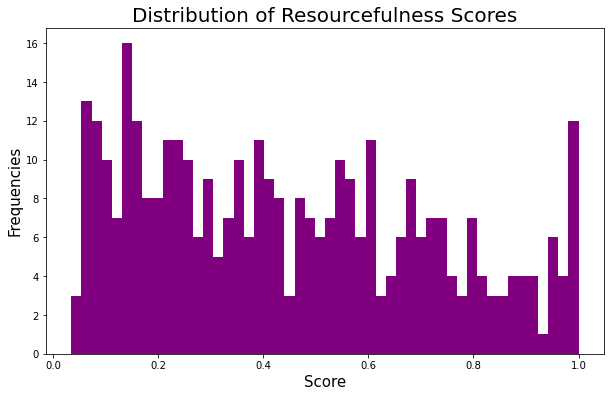

In [38]:
old_score = pd.read_csv('Score.csv')
plt.figure(figsize=(10,6))
plt.hist(old_score['score'], bins=50, color='Purple')
plt.title('Distribution of Resourcefulness Scores', size=20)
plt.xlabel('Score', size=15)
plt.ylabel('Frequencies', size=15)

Text(0, 0.5, 'Frequencies')

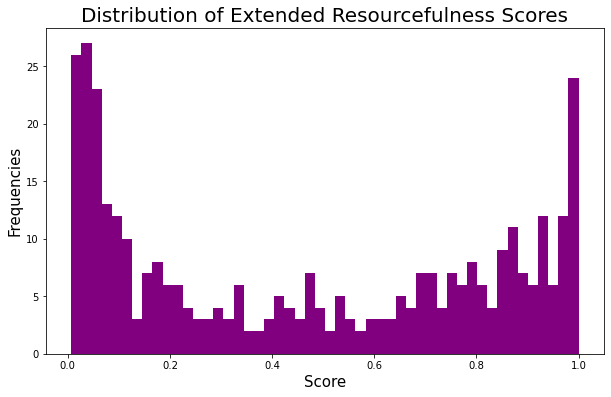

In [39]:
score = pd.read_csv('Final_Score.csv')
plt.figure(figsize=(10,6))
plt.hist(score['score'], bins=50, color='Purple')
plt.title('Distribution of Extended Resourcefulness Scores', size=20)
plt.xlabel('Score', size=15)
plt.ylabel('Frequencies', size=15)

In [40]:
df1 = pd.merge(SA2og, score[['sa2_code', 'score']], on=['sa2_code'])
df1

,sa2_code,sa2_name,geometry,score
0,102011028,Avoca Beach - Copacabana,"POLYGON ((151.41373 -33.46558, 151.41362 -33.4...",0.375817
1,102011029,Box Head - MacMasters Beach,"POLYGON ((151.37484 -33.50052, 151.37507 -33.5...",0.424864
2,102011030,Calga - Kulnura,"MULTIPOLYGON (((151.20449 -33.53280, 151.20448...",0.997344
3,102011031,Erina - Green Point,"POLYGON ((151.37194 -33.43698, 151.37288 -33.4...",0.983574
4,102011032,Gosford - Springfield,"POLYGON ((151.32349 -33.42779, 151.32342 -33.4...",0.996499
...,...,...,...,...
355,128021536,Oyster Bay - Como - Jannali,"POLYGON ((151.07861 -33.99748, 151.07861 -33.9...",0.798378
356,128021538,Sutherland - Kirrawee,"POLYGON ((151.05006 -34.02158, 151.05008 -34.0...",0.792964
357,128021607,Engadine,"POLYGON ((150.99568 -34.05361, 150.99570 -34.0...",0.217182
358,128021608,Loftus - Yarrawarrah,"POLYGON ((151.03955 -34.04175, 151.03954 -34.0...",0.035188


Text(0.5, 1.0, 'Greater Sydney')

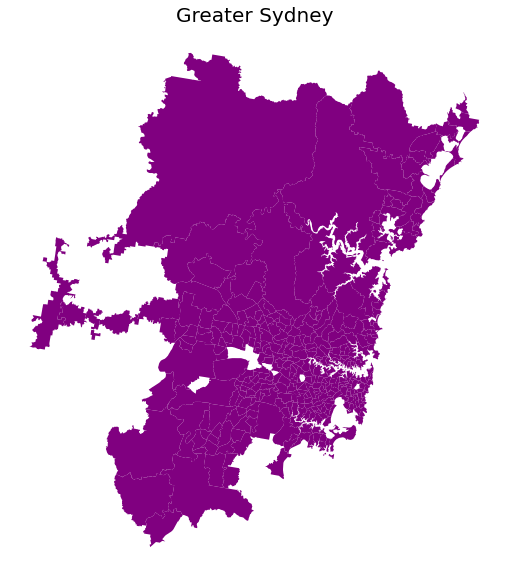

In [41]:
df1.plot(figsize=(15,10), color='Purple')
plt.axis('off')
plt.title('Greater Sydney', size =20)

Text(0.5, 1.0, 'Resourcefulness of Greater Sydney')

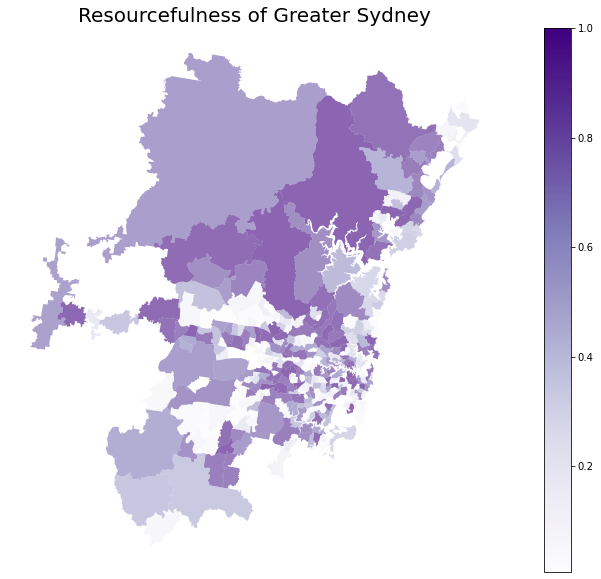

In [42]:
fig, ax = plt.subplots(figsize=(15,10))
img1=df1.plot(column='score', cmap ='Purples', legend = True, ax=ax, linewidth=0, edgecolor='Black', alpha=0.6) 
plt.axis('off')
plt.title('Resourcefulness of Greater Sydney', size =20)

### Correlation

In [43]:
table = pd.merge(score, income, how='inner')
table = table[['sa2_code', 'score', 'median_income']]

In [44]:
# Correlation coefficient matrix 
cr = np.corrcoef(table['score'], table['median_income'])
cr

array([[1.        , 0.08209167],
       [0.08209167, 1.        ]])

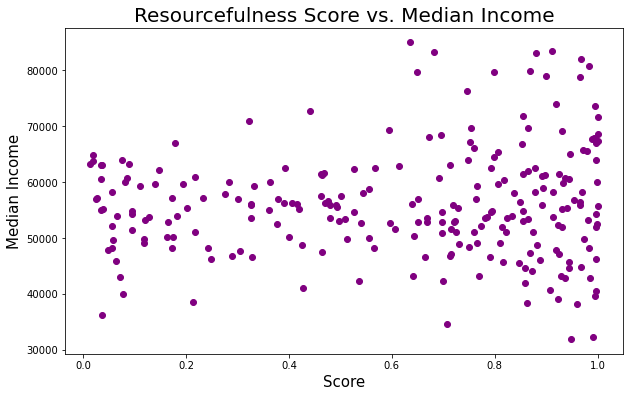

In [45]:
plt.figure(figsize=(10,6))
plt.scatter(table['score'], table['median_income'], color='purple')
plt.title("Resourcefulness Score vs. Median Income", size = 20)
plt.xlabel("Score", size=15)
plt.ylabel("Median Income", size=15)
plt.show()